In [134]:
import pandas as pd
import numpy as np
pd.options.display.max_colwidth=3000

import os
import datetime

import spacy
from spacy.matcher import Matcher
from spacy.tokens import Doc
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA

import re
import emoji
import string
import nltk

import html

from collections import  defaultdict, Counter
from itertools import islice
import tqdm

import utils 
import json
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

## Read the data

Read tickers list

In [2]:
with open('./tickers.txt', 'r') as f:
    ticker_list = [t.strip() for t in f.readlines()]

Read data from stocktwits

In [3]:
def multiple_replace(sub_dict, text):
    if not sub_dict:
        return text

    regex = re.compile("(%s)" % "|".join(map(re.escape, sub_dict.keys())))
    return regex.sub(lambda mo: sub_dict[mo.string[mo.start():mo.end()]], text) 

In [4]:
def load_stocktwits_data(path):
    result = []

    for ticker in ticker_list:
        texts = []
        files = os.listdir(path)
        
        for file in filter(lambda x: x.startswith(ticker + '_'), files):
            with open(os.path.join(path, file), 'r') as f:
                data = json.load(f)
                
            for msg in data:
                text = msg['body']
                # delete $ sign before any ticker
                sub_dict = {'$' + symbol['symbol']: symbol['symbol'] for symbol in msg['symbols']}
                text = multiple_replace(sub_dict, text)
                texts.append(text)

        df = pd.DataFrame({'text': list(set(texts))})
        df['ticker'] = ticker
        df['label'] = 1
        
        result.append(df)
        
    return result

In [5]:
df_stock = pd.concat(
    load_stocktwits_data('./stocktwits_hope'),
    axis=0
).reset_index(drop=True)

For 5 tickers there was no data on stocktwits.com

In [6]:
df_stock['ticker'].nunique()

45

**Read twitter data**

In [7]:
def load_twitter_data(path):
    result = []
    
    for ticker in ticker_list:
        texts = []
        files = os.listdir(path)
        
        for file in filter(lambda x: x.startswith(ticker + '_'), files):
            with open(os.path.join(path, file), 'r') as f:
                texts.extend(set(t.strip() for t in f.readlines()))

        df = pd.DataFrame({'text': list(set(texts))})
        df['ticker'] = ticker
        df['label'] = 0
        
        result.append(df)  
        
    return result

In [8]:
df_twitter = pd.concat(
    load_twitter_data('./twitter'),
    axis=0
).reset_index(drop=True)

On `twitter.com` there were tweets for every ticker

In [9]:
df_twitter['ticker'].nunique()

50

---

In [10]:
df_all = pd.concat(
    [
        df_twitter,
        df_stock
    ],
    axis=0
).reset_index(drop=True)

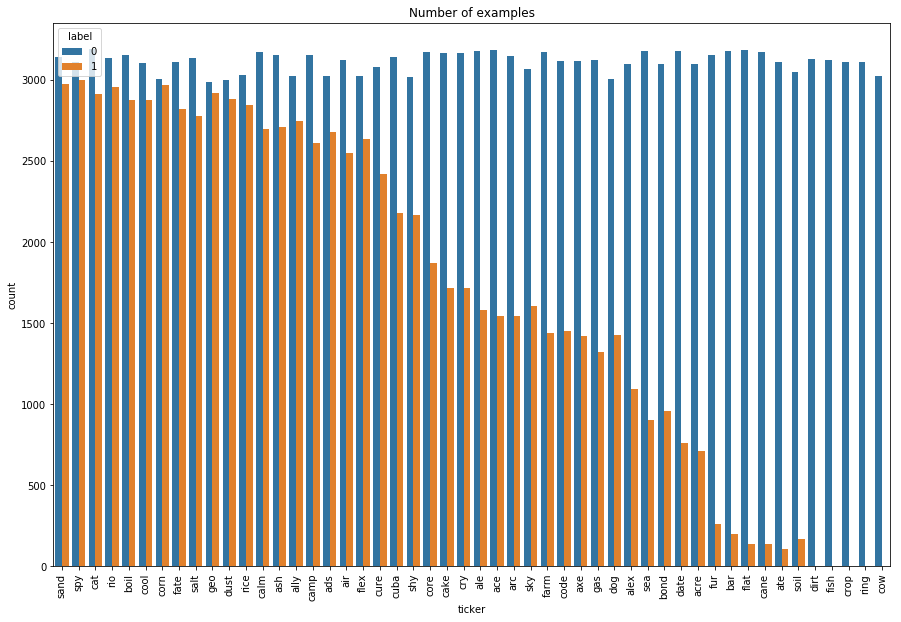

In [11]:
plt.figure(figsize=(15,10))
sns.countplot(
    df_all['ticker'], 
    order=list(df_all.loc[:, 'ticker'].value_counts().index),
    hue=df_all['label']
)
plt.xticks(rotation='vertical')
plt.title('Number of examples')
plt.show()

The 0 label corresponds to non-ticker examples.
* Found just right amount of data for every ticker

The 1 label corresponds to ticker examples 
* Stocktwits.com could not provide  with 3000 examples for some tickers 

#### Class balance

The data is pretty balanced, as it was planned. 

No data augmentation needed, roc_auc metric can be used.

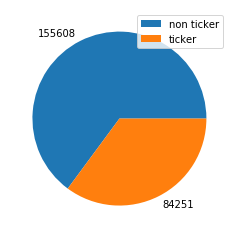

In [12]:
plt.pie(df_all['label'].value_counts().values, labels=df_all['label'].value_counts().values)
plt.legend(['non ticker', 'ticker'])
plt.show()

## Cleaning data

in order to clean the tweet the following operations should be done:
    * html.unescape

    * replace url entities with URL_ENT (regex)
    * replace pic entities with PICTURE_ENT (regex)
    * replace user entities with USER_ENT (regex)

    * replace \s simbols with ' ' to prevent spacy tokens like '    ' 
    * replace date entities with DATE_ENT (spacy)
    * replace person entities with PERSON_ENT (spacy)
    * replace money entities with MONEY_ENT (spacy)
    * replace number entities with NUMBER_ENT (regex)

    * remove punctuation except '!' and '?' (string)
    * remove stopwords (nltk)

In [13]:
url_regex = re.compile(
    r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
    re.IGNORECASE
)
user_regex = re.compile(r'@\w[\w\d_]+')
pic_regex = re.compile(r'pic.twitter(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

def replace_url(text):
    return re.sub(url_regex, ' URL_ENT ', text)

def replace_user(text):
    return re.sub(user_regex, ' PERSON_ENT ', text)

def replace_pic(text):
    return re.sub(pic_regex, ' PICTURE_ENT ', text)

In [14]:
stopwords = set(nltk.corpus.stopwords.words('english'))
punct_regex = re.compile('[' + re.escape(r'"#%&\'()*+,-./:;<=>@[\\]^_`{|}~$') + ']+')
number_regex = re.compile(r'\d+[\d\.\,]*')
bad_name_regex = re.compile(r'[A-Z]{3,}')
bad_name_set = {'DATE_ENT', 'NUMBER_ENT', 'URL_ENT', 'PICTURE_ENT', 'PERSON_ENT', 'MONEY_ENT', 'PERCENT_ENT'}
tickers_set = set(ticker_list)

def replace_tokens(doc):
    """ this function extracts entities and removes tokens from `spacy.doc`
        input: `spacy.doc` - initial document 
        output: `spacy.doc` - cleaned document
    """
    new_words = []
    idx_to_delete = []
    
    for index, token in enumerate(doc):
        
        if token.text.lower() in tickers_set:
            new_words.append(token.text)
            continue
        
        if token.ent_type_ == 'DATE':
            new_words.append('DATE_ENT')
            continue
            
        if (
                token.ent_type_ == 'PERSON' 
                and not re.match(bad_name_regex, token.text)
                and token.text not in bad_name_set
        ):
            new_words.append('PERSON_ENT')
            continue
            
        if token.ent_type_ == 'PERCENT' and token.text.isdigit():
            new_words.append('PERCENT_ENT')
            continue
            
        if token.ent_type_ == 'MONEY' and token.text.isdigit():
            new_words.append('MONEY_ENT')
            continue
            
        if re.match(number_regex, token.text):
            new_words.append('NUMBER_ENT')
            continue
            
        if re.match(punct_regex, token.text):
            idx_to_delete.append(index)
            continue
            
        if token.text.lower() in stopwords:
            idx_to_delete.append(index)
            continue
            
        new_words.append(token.text)
    
    atrr_array = doc.to_array([LOWER, POS, ENT_TYPE, IS_ALPHA])
    atrr_array = np.delete(atrr_array, idx_to_delete, axis=0)

    new_doc = Doc(doc.vocab, words=new_words)
    
    new_doc.from_array([LOWER, POS, ENT_TYPE, IS_ALPHA], atrr_array)
    
    return new_doc

In [15]:
nlp = spacy.load('en_core_web_sm')

In [16]:
def clean_text(text):
    """ cleans the text
        input: text as one string
        output: spacy.doc
    """
    text = html.unescape(text)
    text = replace_url(text)
    text = replace_pic(text)
    text = replace_user(text)
    text = re.sub('\s+', ' ', text)
    doc = nlp(text)
    doc = replace_tokens(doc)
    
    return doc

In [17]:
docs = []

for text in tqdm.tqdm(df_all['text'].values):
    docs.append(clean_text(text))

100%|██████████| 239859/239859 [44:19<00:00, 90.19it/s] 


In [18]:
df_all.loc[:, 'doc']  = docs

In [19]:
df_all.head(3)

,text,ticker,label,doc
0,Got one. We'll keep trying to get the dirt too pic.twitter.com/2mKFdx7dLN,dirt,0,"(Got, one, keep, trying, get, dirt, PICTURE_ENT)"
1,It dosnt matter i mean dirt bag carrag her see at name that means ge comes from orphanage some 1 in his family was likly a broken whore and raised probly in a catholic 1 hence the name so we know exectly what the scumbag is,dirt,0,"(dosnt, matter, mean, dirt, bag, carrag, see, name, means, ge, comes, orphanage, NUMBER_ENT, family, likly, broken, whore, raised, probly, catholic, NUMBER_ENT, hence, name, know, exectly, scumbag)"
2,The birth of the Joe Dirt Amendment. pic.twitter.com/iUgWmuqYJo,dirt,0,"(birth, Joe, Dirt, Amendment, PICTURE_ENT)"


## Calculate ticker position

In [20]:
ticker_matcher = Matcher(nlp.vocab)

for name in ticker_list:
    ticker_matcher.add(name, None, [{'LOWER': name.lower()}])

In [21]:
entity_list = ['DATE_ENT', 'NUMBER_ENT', 'URL_ENT', 'PICTURE_ENT', 'PERSON_ENT', 'MONEY_ENT', 'PERCENT_ENT']
entity_matcher = Matcher(nlp.vocab)
    
for name in entity_list:
    entity_matcher.add(name, None, [{'LOWER': name.lower()}])

In [22]:
df_all.loc[:, 'ticker_match']  = df_all['doc'].apply(ticker_matcher)

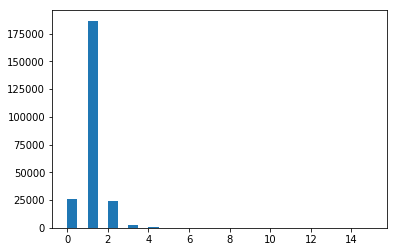

In [23]:
plt.hist(list(map(len, df_all['ticker_match'].values)), bins=30)
plt.show()

Some tweets has no ticker candidates at all, they have to be removed. 

Also, some tweets contain several tickers and they should be copied as different examples depending on position tickers have in doc.

**Drop examples without match**

In [24]:
print('shape before deletion', '\t', df_all.shape)
df_all = df_all.loc[df_all['ticker_match'].apply(lambda x: x != []), :]
print('shape after deletion', '\t', df_all.shape)

shape before deletion 	 (239859, 5)
shape after deletion 	 (213959, 5)


**Copy examples with multiple matches**

In [26]:
new_df = []

for _, row in tqdm.tqdm(df_all.iterrows(), total=df_all.shape[0]):
    for match in row['ticker_match']:
        df = dict()
        df['ticker'] = nlp.vocab.strings[match[0]]
        df['position'] = match[1]
        df['doc'] = row['doc']
        df['label'] = row['label']
        df['text'] = row['text']
        new_df.append(df)
        
df_all = pd.DataFrame(new_df)
print('shape after copying examples', '\t', df_all.shape)

100%|██████████| 213959/213959 [00:27<00:00, 7721.27it/s]


shape after copying examples 	 (245099, 5)


**Now the class balance is better because of Matcher examples copying:**

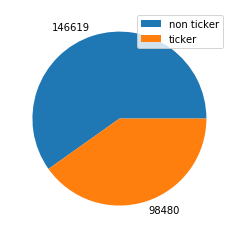

In [27]:
plt.pie(df_all['label'].value_counts().values, labels=df_all['label'].value_counts().values)
plt.legend(['non ticker', 'ticker'])
plt.show()

Now all 50 tickers are present

In [31]:
df_all[df_all['label'] == 1]['ticker'].nunique()

50

Example of what ticker Matcher did with ticker `COW` - found 98 examples

(there was no `COW` ticker examples before)

In [40]:
df_all[(df_all['label'] == 1) & (df_all['ticker'] == 'cow')].shape

(98, 5)

In [39]:
df_all[(df_all['label'] == 1) & (df_all['ticker'] == 'cow')].loc[174379].reset_index().T

,0,1,2,3,4
index,doc,label,position,text,ticker
174379,"(Agriculture, ETF, MOO, lost, NUMBER_ENT, NUMBER_ENT, DATE_ENT, DATE_ENT, remains, NUMBER_ENT, momentum, trending, DBA, SOIL, COW)",1,14,"Agriculture ETF MOO lost 0.23 (0.43%) last week, remains below 20-dMA; S/T momentum trending down. DBA SOIL $COW",cow


for `RING` and `CROP` tickers -  got some relevant examples

for `FISH` and `DIRT` - found only bad examples (these words are not tickers there) 

but: 
    * number of examples very small
    * we still have the stockmarket context around them :) 

## Features

The following features were calculated:
    * length of clean tweet (spacy tokens count)
    * lengths of words in clean tweet (median, mean, max)
    * absolute minimal distances to all entities (missing values filled with 999)
    * relative position in the document
    * presense of '!', '?',  any emoji, special emoji

Also another features were tested: presence of top_words and presense of top_verbs.

But:

* none of them was in top-50 xgboost features
* it took too much time to calculate top_words on each fold during cross validation 
* tf-idf, in my opinion, gets the top words very well

That is why top_words features are not implemented

In [50]:
special_emoji_regex = re.compile(r'[\🚀\🔥\👀\🤑\🐻\📈\💰\🤔\💲\💵\💸\€\£]+', re.UNICODE)

def has_special_emoji(text):
    return len(re.findall(special_emoji_regex, text)) > 0

def has_emoji(text):
    emoji_list = []
    data = re.findall(r'\W', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    return len(emoji_list) > 0

def get_distances_to_ents(doc, tic_pos):
    res_dict = defaultdict(lambda: 999)
    
    for res in entity_matcher(doc):
        key = nlp.vocab.strings[res[0]]
        res_dict[key] = min(res_dict[key], abs(tic_pos - res[1]))
    
    return res_dict

def get_features(doc, tic_pos):
    doc_text = doc.text
    one_ex_dict = dict()
    
    one_ex_dict['word_count'] = len(doc)
    word_lens = [len(tok) for tok in doc]
    one_ex_dict['word_max'] = np.max(word_lens)
    one_ex_dict['word_mean'] = np.mean(word_lens)
    one_ex_dict['word_median'] = np.median(word_lens)
    
    ticker = doc[tic_pos]
    
    one_ex_dict['relative_pos'] = tic_pos / len(doc)
    
    distances_to_ents = get_distances_to_ents(doc, tic_pos)
    for ent in entity_list:
        one_ex_dict['{}_distance'.format(ent)] = distances_to_ents[ent]
    
    one_ex_dict['has_emoji'] = has_emoji(doc_text)
    one_ex_dict['has_special_emoji'] = has_special_emoji(doc_text)
    
    one_ex_dict['has_!'] = '!' in doc_text
    one_ex_dict['has_?'] = '?' in doc_text
    
    return one_ex_dict

def build_features(df):
    result = []

    for _, row in df.iterrows():
        result.append(get_features(row['doc'], row['position']))
        
    return pd.DataFrame(result)

In [51]:
df_all = pd.concat(
    [
        df_all,
        build_features(df_all)
    ],
    axis=1
)

## Save the results

In [ ]:
nlp.vocab.to_disk('vocab.txt')

In [ ]:
with open('docs.bin', 'wb') as f:
    for doc in tqdm.tqdm(df_all['doc'].values):
        pickle.dump(utils.serialize_doc(doc), f)

In [ ]:
df_all.drop('doc', axis=1, inplace=True)
df_all.to_csv('./df_all.csv', index=None)

## Some analytics

read the features

In [135]:
df_all = pd.read_csv('./all_feats_for_analysis.csv')

In [136]:
vocab = spacy.vocab.Vocab().from_disk('vocab.txt')
docs = []

with open('docs.bin', 'rb') as f:
    while True:
        try:
            docs.append(utils.deserialize_doc(pickle.load(f), vocab))
        except EOFError:
            break

df_all.loc[:, 'doc'] = docs

In [140]:
df_all.tail(1)

,doc,label,position,text,ticker,DATE_ENT_distance,MONEY_ENT_distance,NUMBER_ENT_distance,PERCENT_ENT_distance,PERSON_ENT_distance,...,URL_ENT_distance,has_!,has_?,has_emoji,has_special_emoji,relative_pos,word_count,word_max,word_mean,word_median
245098,"(Entry, Material, Definitive, URL_ENT, FARM)",1,4,Entry into a Material Definitive http://www.conferencecalltranscripts.org/8/summary2/?id=2832355 FARM,farm,999,999,999,999,999,...,1,False,False,False,False,0.8,5,10,6.8,7.0


---

In [52]:
def get_top_words(df, label, pos_filter, stop_words):
    """collects all words for giving label if they are not in stop_list and they passed through pos_filter
        input:
            * df
            * label 
            * pos_filter 
            * stop_words
        output:
            * list of words (alphabetic and lower)
    """
    result = []
    stop_words_set = set(map(lambda x: x.lower(), stop_words))
    
    for words in df.loc[df['label'] == label, 'doc']:
        result.extend(filter(
            lambda x: pos_filter(x.pos_) and x.text.lower() not in stop_words_set and x.text.isalpha(),
            words
        ))
        
    return list(map(lambda x: str(x).lower(), result))

def top_wrds(words, count=20):
    return [x for x, _ in Counter(words).most_common(count)]

def get_top_words_exclusive(words_a, words_b, count=10, exclude_count=100):
    """gets top words from list A, so that they are not in top words from list B
        input:
            * words_a - list of words A, 
            * words_b - list of words B, 
            * count - number of top words from list A to return, 
            * exclude_count - number of top words from list B to check.
        ouput:
            * top words from list A
    """
    def fst(x):
        "first element"
        return x[0]
    
    words_a_cnt = Counter(words_a)
    words_b_cnt = Counter(words_b)
    
    return list(islice(
        (x for x, _ in words_a_cnt.most_common() 
        if x not in set(map(fst, words_b_cnt.most_common(exclude_count)))),
        count
    ))

In [53]:
stop_words = entity_list + ticker_list

non_ticker_words = get_top_words(df_all, 0, lambda pos: pos != 'VERB', stop_words)
ticker_words = get_top_words(df_all, 1, lambda pos: pos != 'VERB', stop_words)

non_ticker_verbs = get_top_words(df_all, 0, lambda pos: pos == 'VERB', stop_words)
ticker_verbs = get_top_words(df_all, 1, lambda pos: pos == 'VERB', stop_words)

In [54]:
non_ticker_words_top = get_top_words_exclusive(non_ticker_words, ticker_words)
ticker_words_top = get_top_words_exclusive(ticker_words, non_ticker_words)

non_ticker_verbs_top = get_top_words_exclusive(non_ticker_verbs, ticker_verbs)
ticker_verbs_top = get_top_words_exclusive(ticker_verbs, non_ticker_verbs)

These are 

**top 10 words/verbs for tickers** 

that are not represented in top 100 for non-tickers

In [55]:
ticker_words_top

['shares',
 'short',
 'earnings',
 'eps',
 'insider',
 'volume',
 'market',
 'estimize',
 'chart',
 'ugaz']

In [56]:
ticker_verbs_top

['reporting',
 'expecting',
 'filed',
 'report',
 'settled',
 'sold',
 'estimates',
 'disposed',
 'announces',
 'picked']

**Top words/verbs for ticker and non-tiker examples**

In [57]:
pd.DataFrame({
    'top_non_ticker_words': top_wrds(non_ticker_words),
    'top_ticker_words': top_wrds(ticker_words),
    'top_non_ticker_verbs': top_wrds(non_ticker_verbs),
    'top_ticker_verbs': top_wrds(ticker_verbs), 
})

,top_non_ticker_verbs,top_non_ticker_words,top_ticker_verbs,top_ticker_words
0,get,like,reporting,shares
1,would,one,expecting,short
2,know,time,filed,earnings
3,got,people,see,eps
4,go,new,buy,insider
5,make,good,report,volume
6,see,us,settled,market
7,think,really,going,estimize
8,want,back,get,chart
9,could,even,sold,ugaz


---

In [93]:
def get_emoji(text):
    emoji_list = []
    data = re.findall(r'\W', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    return emoji_list

In [114]:
emoji_non_ticker = Counter(get_emoji(
        ' '.join(df_all[(df_all['has_emoji'] == 1)&(df_all['label'] == 0)]['text'].values)
    )
)
emoji_ticker = Counter(get_emoji(
        ' '.join(df_all[(df_all['has_emoji'] == 1)&(df_all['label'] == 1)]['text'].values)
    )
)

In [141]:
df_emoji_non_tic = pd.DataFrame({
    'emoji_non_ticker': [x[0] for x, _ in emoji_non_ticker.most_common(10)]}) 
df_emoji_tic = pd.DataFrame({
    'emoji_ticker': [x[0] for x, _ in emoji_ticker.most_common(10)]}) 

In [142]:
pd.concat([df_emoji_non_tic, df_emoji_tic], axis=1).fillna('')

,emoji_non_ticker,emoji_ticker
0,®,🚀
1,™,😂
2,©,👍
3,⬆,🔥
4,‼,🤑
5,▪,👀
6,,💰
7,,🐻
8,,📈
9,,🤔


___________________

### Feature correlation

As `distance features` empty values were filled with `999`, it explains the following correlations:  
* `label` is in negative correlation with `number_ent_distance`, `url_ent_distance`, `has_!`
* `label` is in positive correlation with `picture_ent_distance`

And these correlations are obvious:
* `has_emoji` and `has_special_emoji` are highly correlated
* `word_max` and `word_mean` are highly correlated 

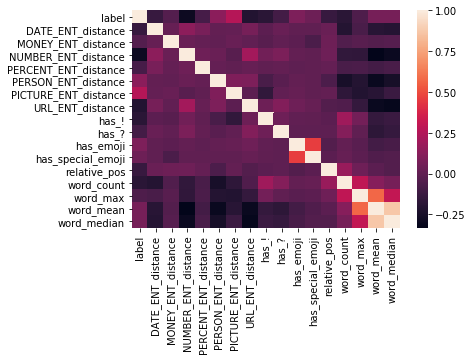

In [59]:
sns.heatmap(df_all.drop(['doc', 'text', 'position'], axis=1).corr())
plt.show()

---

### Box plots for length stats

* `max length` of non-ticker words has much wider range, than ticker words have
* non-ticker tweets are `longer`, than ticker tweets

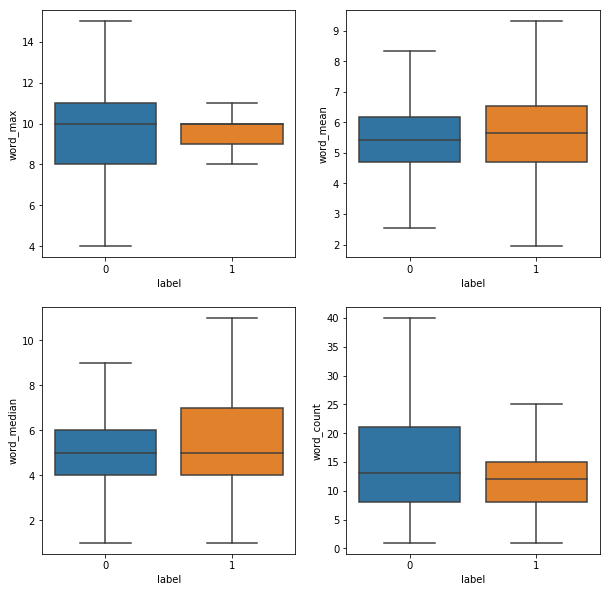

In [61]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, feature in enumerate(['word_max', 'word_mean', 'word_median', 'word_count']):
    sns.boxplot(data=df_all, y=feature, x='label', showfliers=False, ax=axs[i//2,i%2])
plt.show()

---

### Countplot for binary features

* non-ticker tweets have `!` and `?` much more often
* while ticker tweets have special money-related `emoji`

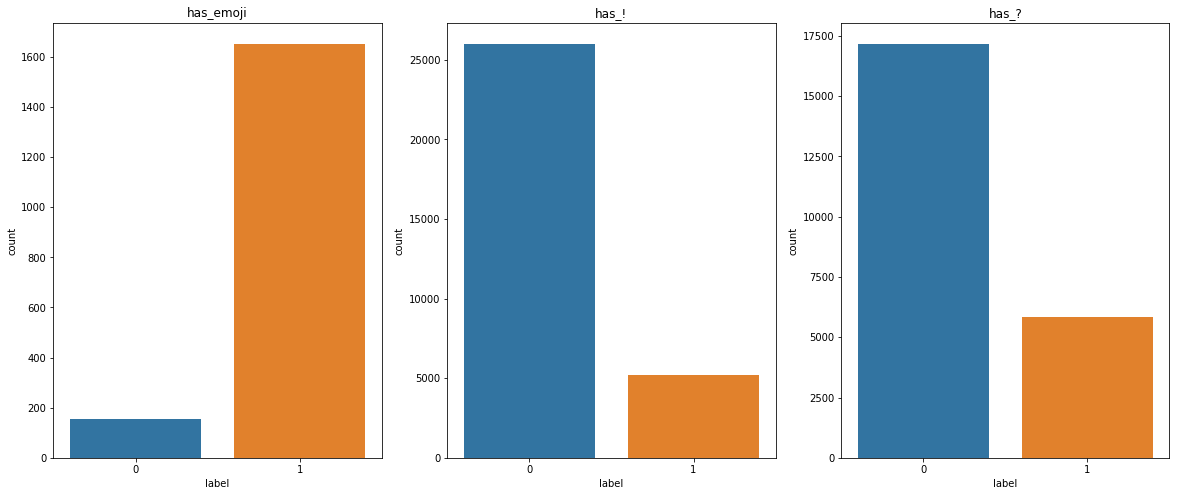

In [79]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
for i, feature in enumerate(['has_emoji', 'has_!', 'has_?']):
    sns.countplot(data=df_all[df_all[feature] == 1], x='label', ax=axs[i%3])
    axs[i%3].set_title(feature)
plt.show()

---

### Kdeplots for numerical features

* by `relative_position` we can assume, that tickers often take the first positions in the document

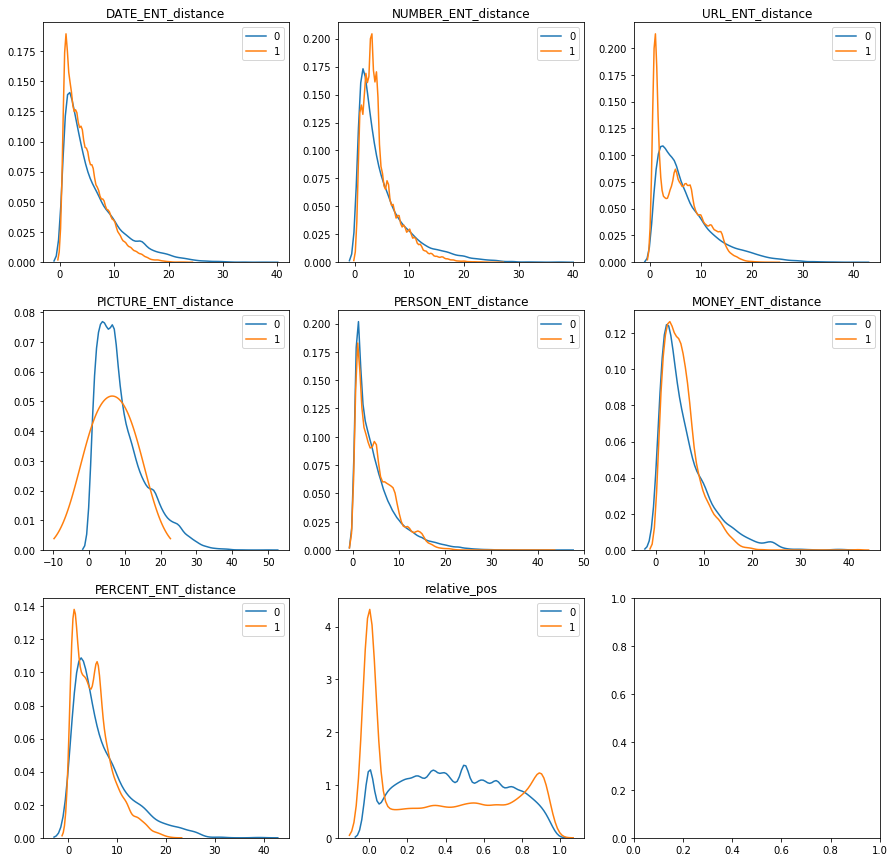

In [133]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, feature in enumerate(['{}_distance'.format(ent) for ent in entity_list] + ['relative_pos']):
    df = df_all.loc[df_all[feature] < 999]
    sns.kdeplot(df.loc[df['label'] == 0, feature], label='0',ax=axs[i//3,i%3]);
    sns.kdeplot(df.loc[df['label'] == 1, feature], label='1', ax=axs[i//3,i%3]);
    axs[i//3,i%3].legend();
    axs[i//3,i%3].set_title(feature);
plt.show()

---